# PRE
---

In [2]:
import os
import cv2
import numpy as np
from tensorflow import keras
import tensorflow as tf

np.random.RandomState(7)


def read_images_of(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            image = image / 255.0
            if image is not None:
                images.append(image)
    images = np.array(images)
    return images


cats_train = read_images_of("../data/HW2_Dataset/Train/Cats")
cats_test = read_images_of("../data/HW2_Dataset/Test/Cats")
dogs_train = read_images_of("../data/HW2_Dataset/Train/Dogs")
dogs_test = read_images_of("../data/HW2_Dataset/Test/Dogs")

In [3]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

train_data = np.concatenate((cats_train, dogs_train), axis=0)
cats_label = np.ones(cats_train.shape[0], dtype=int)
dogs_label = np.zeros(dogs_train.shape[0], dtype=int)
train_labels = np.concatenate((cats_label, dogs_label), axis=0).reshape(-1, 1)


shuffle_indices = np.random.permutation(train_data.shape[0])
train_data = train_data[shuffle_indices]
train_labels = train_labels[shuffle_indices]
train_labels = encoder.fit_transform(train_labels)


test_data = np.concatenate((cats_test, dogs_test), axis=0)
cats_label = np.ones(cats_test.shape[0], dtype=int)
dogs_label = np.zeros(dogs_test.shape[0], dtype=int)
test_labels = np.concatenate((cats_label, dogs_label), axis=0).reshape(-1, 1)

shuffle_indices = np.random.permutation(test_data.shape[0])
test_data = test_data[shuffle_indices]
test_labels = test_labels[shuffle_indices]
test_labels = encoder.fit_transform(test_labels)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.3, random_state=7)

In [5]:
len(X_train), len(X_valid), len(y_train), len(y_valid)

(491, 211, 491, 211)

In [6]:
import matplotlib.pyplot as plt


def plot_metrics(history):

    fig, axs = plt.subplots(2, 1, figsize=(8, 8))

    axs[0].plot(history.history["loss"], label="Training Loss")
    axs[0].plot(history.history["val_loss"], label="Validation Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(history.history["accuracy"], label="Training Accuracy")
    axs[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    rotation_range = 30,
    zoom_range = (0.75, 1.25)
).flow(
    x = X_train,
    y = y_train,
    batch_size = 49
)


valid_datagen = ImageDataGenerator().flow(
    x = X_valid,
    y = y_valid,
    batch_size = 10 * len(X_valid)
)

KeyboardInterrupt: 

In [76]:
len(train_datagen), len(valid_datagen)

(11, 1)

In [37]:
def evaluate_test(model):
    with tf.device("/cpu:0"):
        y_pred = model.predict(test_data)
        y_pred = np.argmax(y_pred, axis = 1)
        y_true = np.argmax(test_labels, axis = 1)
        acc = np.mean(y_true == y_pred)
        print(acc)

In [38]:
def save_weights(model, weights_path):
    model.save_weights(weights_path)
    print("Saved model to disk")

def load_weights(model, weights_path:str):
    model.load_weights(weights_path)
    print("Loaded model from disk")

    return model

In [39]:
# vgg16_model = VGG16(input_shape=(224, 224, 3), include_top = False, weights = 'imagenet')
# vgg16_model.trainable = False
# x = vgg16_model.output
# x = Layers.BatchNormalization(name = 'BatchNormalization')(x)
# x = Layers.GlobalAveragePooling2D()(x)
# x = Layers.Dropout(0.5)(x)
# x = Layers.Dense(256)(x)
# x = Layers.LeakyReLU(alpha=0.1)(x)
# x = Layers.Dropout(0.25)(x)
# outputs = Layers.Dense(2, activation = 'softmax')(x)

# model = Model(inputs = vgg16_model.input, outputs = outputs)
# model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# model.summary()

# MODELS
---

In [40]:
from keras.applications import VGG16, ResNet50
from keras.models import Sequential
from keras import layers as Layers

def scheduler(epoch, lr):
    decay_rate = 0.002
    new_lr = lr / (1.0 + decay_rate * epoch)
    return new_lr

LR_sched = keras.callbacks.LearningRateScheduler(scheduler)    

In [41]:
def create_model_vgg16():

    cnn_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    model = Sequential()
    model.add(cnn_base)
    model.add(Layers.Flatten())
    model.add(Layers.Dense(512, activation="relu"))
    model.add(Layers.BatchNormalization())
    model.add(Layers.Dropout(0.5))
    model.add(Layers.Dense(512, activation="relu"))
    model.add(Layers.Dropout(0.5))
    model.add(Layers.Dense(2, activation="softmax"))
    return cnn_base, model

In [42]:
# _, model = create_model_vgg16()
# _.trainable = False
# model.summary()

In [43]:
def create_model_resnet50():
    cnn_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    
    model = Sequential()
    model.add(cnn_base)
    model.add(Layers.GlobalMaxPool2D())
    model.add(Layers.BatchNormalization())
    model.add(Layers.Dense(256, activation="relu"))
    model.add(Layers.Dropout(0.5))
    model.add(Layers.Dense(32, activation="relu"))
    model.add(Layers.Dropout(0.3))
    model.add(Layers.Dense(2, activation="softmax"))
    return cnn_base, model


# VGG16 - BASE

---

In [44]:
# cnn_base, model = create_model_vgg16()

# cnn_base.trainable = False
# model.summary(show_trainable=True)

In [45]:
import tensorflow as tf

# optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# model.compile(
#     optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
# )

# with tf.device("/gpu:0"):
#     history = model.fit(
#         x=X_train,
#         y=y_train,
#         epochs=15,
#         batch_size=10,
#         validation_data=(X_valid, y_valid),
#         callbacks=[LR_sched],
#     )

In [46]:
# plot_metrics(history)

In [47]:
# print("Learning rate:", optimizer.learning_rate.numpy())
# evaluate_test(model)

In [48]:
# save_weights(model, weights_path="../models/base_model_vgg16.keras")

# VGG16 - NO AUG
---

In [49]:
cnn_base, model = create_model_vgg16()
# load_weights(model, weights_path="../models/base_model_vgg16.keras")

In [50]:
cnn_base.trainable = True

set_trainable = False
for layer in cnn_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                      

In [51]:
optimizer = keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

with tf.device("/gpu:0"):
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=10,
        batch_size=10,
        validation_data=(X_valid, y_valid),
        callbacks=[LR_sched],
    )

Epoch 1/10
50/50 [==============================] - 5s 99ms/step - loss: 1.1211 - accuracy: 0.5397 - val_loss: 0.7160 - val_accuracy: 0.5118 - lr: 2.0000e-05
Epoch 2/10
50/50 [==============================] - 5s 95ms/step - loss: 0.8526 - accuracy: 0.6273 - val_loss: 0.5851 - val_accuracy: 0.6445 - lr: 1.9960e-05
Epoch 3/10
50/50 [==============================] - 5s 95ms/step - loss: 0.7476 - accuracy: 0.6802 - val_loss: 0.4582 - val_accuracy: 0.7962 - lr: 1.9881e-05
Epoch 4/10
50/50 [==============================] - 5s 95ms/step - loss: 0.5493 - accuracy: 0.7556 - val_loss: 0.3715 - val_accuracy: 0.8626 - lr: 1.9762e-05
Epoch 5/10
50/50 [==============================] - 5s 93ms/step - loss: 0.4995 - accuracy: 0.7882 - val_loss: 0.3257 - val_accuracy: 0.8673 - lr: 1.9605e-05
Epoch 6/10
50/50 [==============================] - 5s 96ms/step - loss: 0.5169 - accuracy: 0.7597 - val_loss: 0.3074 - val_accuracy: 0.9005 - lr: 1.9411e-05
Epoch 7/10
50/50 [==============================] - 

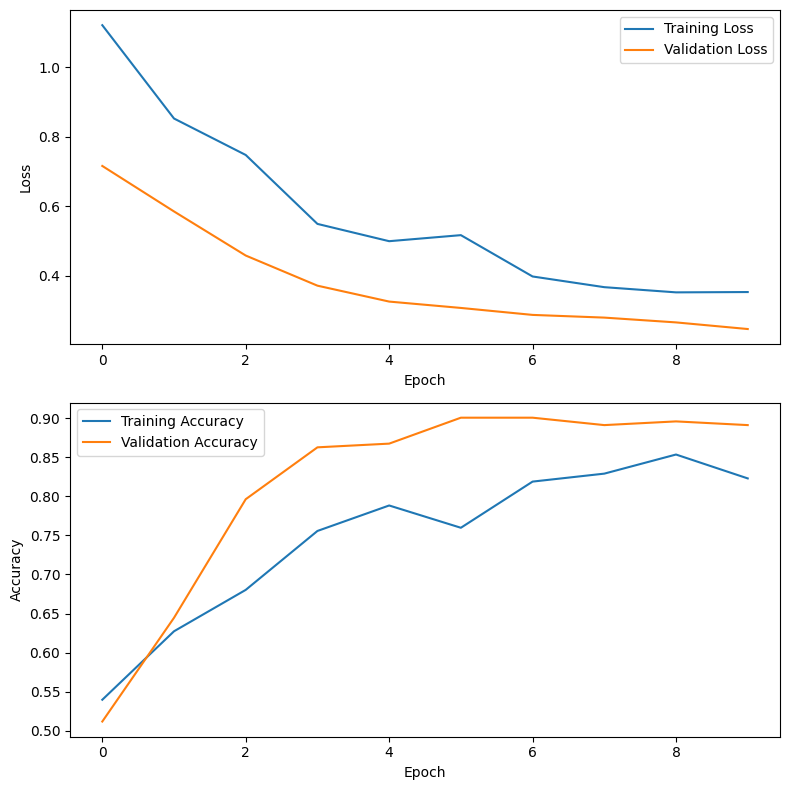

In [52]:
plot_metrics(history)

In [53]:
evaluate_test(model)

4/4 [==============================] - 7s 2s/step
0.87


# VGG16 - AUG

---

In [54]:
cnn_base, model = create_model_vgg16()
# model = load_weights(model, weights_path="../models/base_model_vgg16.keras")

In [55]:
cnn_base.trainable = True

set_trainable = False
for layer in cnn_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               12845568  
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                      

In [60]:
import tensorflow as tf

optimizer = keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

with tf.device("/gpu:0"):
    history = model.fit(
        x=train_datagen,
        epochs=10,
        steps_per_epoch=5,
        batch_size=10,
        validation_data=valid_datagen,
        validation_steps=10,
        callbacks=[LR_sched],
    )

AttributeError: 'list' object has no attribute 'shape'

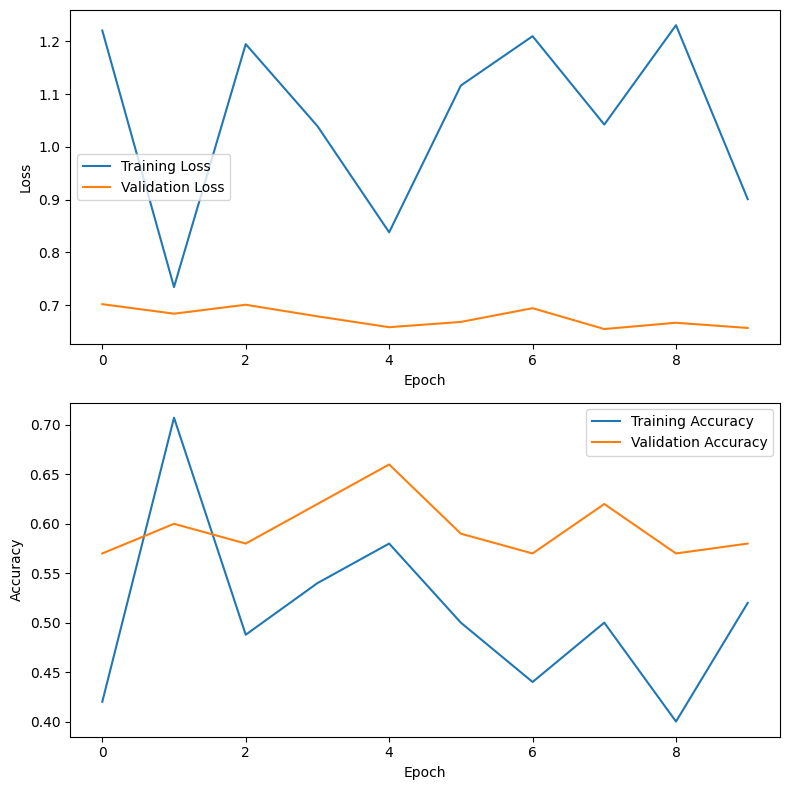

In [ ]:
plot_metrics(history)

In [ ]:
evaluate_test(model)

4/4 [==============================] - 13s 3s/step
0.86


# RESNET50 - Base
---

In [37]:
cnn_base, model = create_model_resnet50()

cnn_base.trainable = False
model.summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  N          
                                                                            
 global_max_pooling2d (Globa  (None, 2048)             0         Y          
 lMaxPooling2D)                                                             
                                                                            
 batch_normalization (BatchN  (None, 2048)             8192      Y          
 ormalization)                                                              
                                                                            
 dense (Dense)               (None, 256)               524544    Y          
                                                                            
 dropout (Dropout)           (None, 256)               0

Epoch 1/50
50/50 [==============================] - 22s 306ms/step - loss: 0.7411 - accuracy: 0.5866 - val_loss: 0.8232 - val_accuracy: 0.4976 - lr: 0.0100
Epoch 2/50
50/50 [==============================] - 14s 277ms/step - loss: 0.6619 - accuracy: 0.6395 - val_loss: 0.6840 - val_accuracy: 0.4834 - lr: 0.0100
Epoch 3/50
50/50 [==============================] - 14s 278ms/step - loss: 0.6608 - accuracy: 0.6334 - val_loss: 0.6864 - val_accuracy: 0.5166 - lr: 0.0099
Epoch 4/50
50/50 [==============================] - 14s 278ms/step - loss: 0.5862 - accuracy: 0.7108 - val_loss: 0.6828 - val_accuracy: 0.5213 - lr: 0.0099
Epoch 5/50
50/50 [==============================] - 14s 278ms/step - loss: 0.6150 - accuracy: 0.6843 - val_loss: 0.6623 - val_accuracy: 0.6303 - lr: 0.0098
Epoch 6/50
50/50 [==============================] - 14s 278ms/step - loss: 0.5531 - accuracy: 0.7189 - val_loss: 0.6711 - val_accuracy: 0.6445 - lr: 0.0097
Epoch 7/50
50/50 [==============================] - 14s 278ms/st

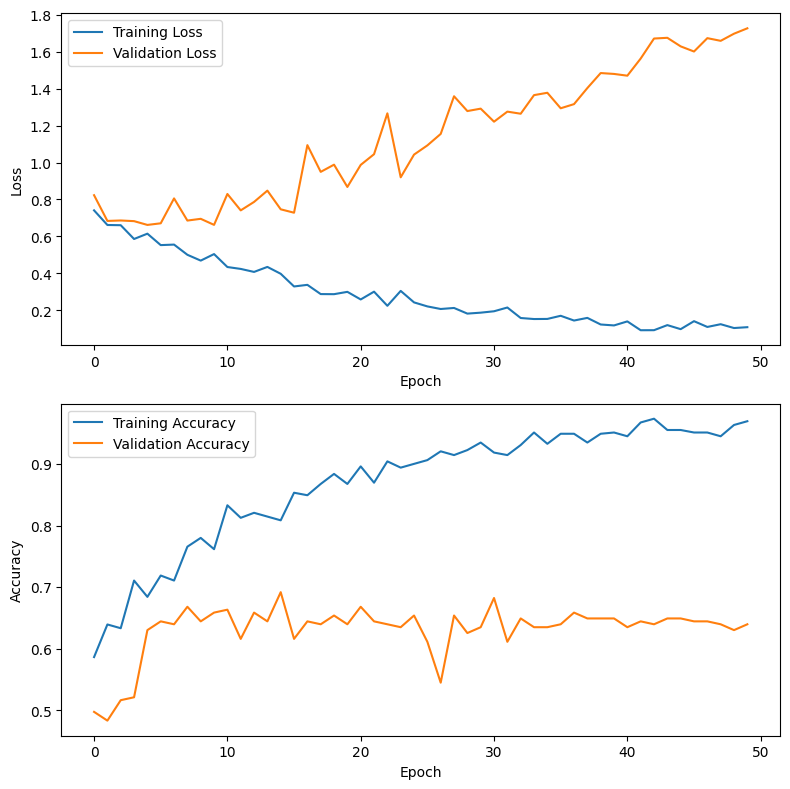

Learning rate: 0.00093207357
4/4 [==============================] - 8s 2s/step
0.64


In [38]:
import tensorflow as tf

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

with tf.device("/gpu:0"):
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=50,
        batch_size=10,
        validation_data=(X_valid, y_valid),
        callbacks=[LR_sched],
    )
plot_metrics(history)

print("Learning rate:", optimizer.learning_rate.numpy())
evaluate_test(model)

In [39]:
save_weights(model, weights_path="../models/resnet50_base.keras")

Saved model to disk


# RESNET50-NO AUG
---

In [ ]:
model = load_weights(weights_path="../models/resnet50_base.keras")

In [ ]:
cnn_base.trainable = True
set_trainable = False
for layer in cnn_base.layers:
    if layer.name == "conv5_block3_1_conv":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# model.summary()

In [ ]:
import tensorflow as tf

optimizer = keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

with tf.device("/gpu:0"):
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=10,
        batch_size=10,
        validation_data=(X_valid, y_valid),
        callbacks=[LR_sched]
    )
plot_metrics(history)

evaluate_test(model)

# RESNET50-AUG
---

In [22]:
cnn_base, model = create_model_resnet50()
cnn_base.trainable = False
model = load_weights(model, weights_path="../models/resnet50_base.keras")

evaluate_test(model)

Loaded model from disk
4/4 [==============================] - 7s 1s/step
0.64


In [23]:
cnn_base.trainable = True
set_trainable = False
for layer in cnn_base.layers:
    if layer.name == "conv5_block3_1_conv":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# model.summary()

In [24]:
import tensorflow as tf

optimizer = keras.optimizers.SGD(learning_rate=2e-4, momentum=0.9)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

with tf.device("/gpu:0"):
    history = model.fit(
        x=train_datagen,
        epochs=50,
        steps_per_epoch=25,
        batch_size=10,
        validation_data=valid_datagen,
        validation_steps=10,
        callbacks=[LR_sched],
    )
plot_metrics(history)

evaluate_test(model)

Epoch 1/50
25/25 [==============================] - 17s 411ms/step - loss: 2.2298 - accuracy: 0.5360 - val_loss: 0.6611 - val_accuracy: 0.6500 - lr: 2.0000e-04
Epoch 2/50
25/25 [==============================] - 9s 369ms/step - loss: 1.4920 - accuracy: 0.6000 - val_loss: 8.9675 - val_accuracy: 0.5500 - lr: 1.9960e-04
Epoch 3/50
25/25 [==============================] - 9s 369ms/step - loss: 1.1735 - accuracy: 0.5840 - val_loss: 0.7086 - val_accuracy: 0.4500 - lr: 1.9881e-04
Epoch 4/50
25/25 [==============================] - 9s 370ms/step - loss: 0.8465 - accuracy: 0.6390 - val_loss: 1.6265 - val_accuracy: 0.4400 - lr: 1.9762e-04
Epoch 5/50
25/25 [==============================] - 9s 369ms/step - loss: 0.8266 - accuracy: 0.6120 - val_loss: 2.2120 - val_accuracy: 0.4400 - lr: 1.9605e-04
Epoch 6/50
25/25 [==============================] - 9s 369ms/step - loss: 0.9152 - accuracy: 0.5840 - val_loss: 8.9971 - val_accuracy: 0.5000 - lr: 1.9411e-04
Epoch 7/50
25/25 [===========================

KeyboardInterrupt: 

Input Layer:

Shape: (None, 224, 224, 3)
The input layer expects images with a shape of (224, 224, 3), representing RGB images with a height and width of 224 pixels.
Convolutional Blocks:

The convolutional part of VGG16 consists of five blocks, each containing multiple convolutional layers (with 3x3 filters), followed by a max pooling layer (2x2 pool size). The number of filters increases as you go deeper into the network.

- Block 1:

    - Conv1_1: (None, 224, 224, 64)

    - Conv1_2: (None, 224, 224, 64)

    - MaxPooling1: (None, 112, 112, 64)

- Block 2:

    - Conv2_1: (None, 112, 112, 128)

    - Conv2_2: (None, 112, 112, 128)

    - MaxPooling2: (None, 56, 56, 128)

- Block 3:

    - Conv3_1: (None, 56, 56, 256)

    - Conv3_2: (None, 56, 56, 256)

    - Conv3_3: (None, 56, 56, 256)

    - MaxPooling3: (None, 28, 28, 256)

- Block 4:

    - Conv4_1: (None, 28, 28, 512)

    - Conv4_2: (None, 28, 28, 512)

    - Conv4_3: (None, 28, 28, 512)

    - MaxPooling4: (None, 14, 14, 512)

- Block 5:

    - Conv5_1: (None, 14, 14, 512)

    - Conv5_2: (None, 14, 14, 512)

    - Conv5_3: (None, 14, 14, 512)

    - MaxPooling5: (None, 7, 7, 512)

Fully Connected Layers:
After the convolutional blocks, VGG16 has three fully connected (dense) layers.

- Flatten: (None, 25088)
The output of the last convolutional block is flattened into a 1D array.
- Dense1: (None, 4096)
- Dense2: (None, 4096)
- Dense3: (None, 1000)
The final dense layer has 1000 units, corresponding to the number of classes in the ImageNet dataset, which VGG16 was originally trained on.

- Output Layer: (None, 1000)
The output layer represents the predicted probabilities for each of the 1000 ImageNet classes.